# Transcript Similarity Analysis
This notebook analyzes the presence of 'Person' and 'State' values in the 'translated_thinking' column of the CSV file, using edit distance tolerance. It also reports statistics and visualizes the effect of varying tolerance.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import editdistance
import plot_configs

In [15]:
# Load the CSV file
df = pd.read_csv('prompts/transcript_similarity_scores.csv')
df = df.fillna('')  # Replace NaN with empty string for safety

## Define fuzzy match function with edit distance tolerance
The function returns True if the target string appears in the text with at least the given similarity ratio (1 - normalized edit distance).

In [16]:
def fuzzy_contains(text, target, tolerance=0.75):
    text = str(text).lower()
    target = str(target).lower()
    if not target or not text:
        return False
    n = len(target)
    for i in range(len(text) - n + 1):
        window = text[i:i+n]
        dist = editdistance.eval(window, target)
        similarity = 1 - dist / max(n, len(window))
        if similarity >= tolerance:
            return True
    return False

## Calculate presence for 'Person' and 'State' at 75% tolerance

In [17]:
tolerance = 0.75
df['person_present'] = df.apply(lambda row: fuzzy_contains(row['translated_thinking'], row['Person'], tolerance), axis=1)
df['state_present'] = df.apply(lambda row: fuzzy_contains(row['translated_thinking'], row['State'], tolerance), axis=1)
person_mean = df['person_present'].mean()
person_std = df['person_present'].std()
state_mean = df['state_present'].mean()
state_std = df['state_present'].std()
print(f'Person present: mean={person_mean:.3f}, std={person_std:.3f}')
print(f'State present: mean={state_mean:.3f}, std={state_std:.3f}')

Person present: mean=0.735, std=0.446
State present: mean=0.837, std=0.373


## Plot presence vs edit distance tolerance (50% to 100%)

--- Tolerance bin: 0.50 - 0.53 ---
Sample Person matches:
Person: 'Harper Lee' | Match: 'larger cit' | Similarity: 0.50
Person: 'Susan Hinton' | Match: 'susean ellen' | Similarity: 0.50
No State matches in this bin.
--- Tolerance bin: 0.53 - 0.55 ---
Sample Person matches:
Person: 'Henry David Thoreau' | Match: 'hannah david thatch' | Similarity: 0.53
No State matches in this bin.
--- Tolerance bin: 0.55 - 0.57 ---
No Person matches in this bin.
Sample State matches:
State: 'Wyoming' | Match: 'woman g' | Similarity: 0.57
--- Tolerance bin: 0.57 - 0.60 ---
No Person matches in this bin.
No State matches in this bin.
--- Tolerance bin: 0.60 - 0.62 ---
Sample Person matches:
Person: 'Hunter Thompson' | Match: 'hunter s. thomp' | Similarity: 0.60
No State matches in this bin.
--- Tolerance bin: 0.62 - 0.65 ---
No Person matches in this bin.
Sample State matches:
State: 'Missouri' | Match: 'mississi' | Similarity: 0.62
--- Tolerance bin: 0.65 - 0.68 ---
Sample Person matches:
Person: 'Clara

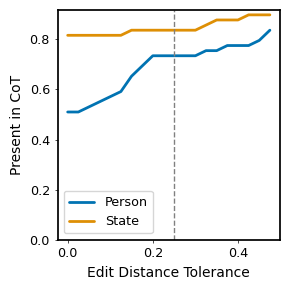

In [37]:
tolerances = np.linspace(0.5, 1.0, 21)
person_rates = []
state_rates = []
rng = np.random.default_rng(42)  # For reproducibility
def get_best_match_and_score(text, target):
    text = str(text).lower()
    target = str(target).lower()
    n = len(target)
    best_sim = -1
    best_window = ''
    for i in range(len(text) - n + 1):
        window = text[i:i+n]
        dist = editdistance.eval(window, target)
        similarity = 1 - dist / max(n, len(window))
        if similarity > best_sim:
            best_sim = similarity
            best_window = window
    return best_window, best_sim

# Precompute all best matches and similarities for efficiency
df['person_best_match'], df['person_best_sim'] = zip(*df.apply(lambda row: get_best_match_and_score(row['translated_thinking'], row['Person']), axis=1))
df['state_best_match'], df['state_best_sim'] = zip(*df.apply(lambda row: get_best_match_and_score(row['translated_thinking'], row['State']), axis=1))

for i in range(len(tolerances)-1):
    tol_low = tolerances[i]
    tol_high = tolerances[i+1]
    # Person bin
    person_bin = df[(df['person_best_sim'] >= tol_low) & (df['person_best_sim'] < tol_high)]
    person_rate = (df['person_best_sim'] >= tol_low).mean()  # For plotting, use cumulative presence
    person_rates.append(person_rate)
    # State bin
    state_bin = df[(df['state_best_sim'] >= tol_low) & (df['state_best_sim'] < tol_high)]
    state_rate = (df['state_best_sim'] >= tol_low).mean()
    state_rates.append(state_rate)
    if tol_high <= 0.76:  # Only print for bins up to 0.75
        print(f'--- Tolerance bin: {tol_low:.2f} - {tol_high:.2f} ---')
        # Person matches
        if not person_bin.empty:
            sample_idx = rng.choice(person_bin.index, size=min(3, len(person_bin)), replace=False)
            print('Sample Person matches:')
            for idx in sample_idx:
                row = person_bin.loc[idx]
                print(f"Person: '{row['Person']}' | Match: '{row['person_best_match']}' | Similarity: {row['person_best_sim']:.2f}")
        else:
            print('No Person matches in this bin.')
        # State matches
        if not state_bin.empty:
            sample_idx = rng.choice(state_bin.index, size=min(3, len(state_bin)), replace=False)
            print('Sample State matches:')
            for idx in sample_idx:
                row = state_bin.loc[idx]
                print(f"State: '{row['State']}' | Match: '{row['state_best_match']}' | Similarity: {row['state_best_sim']:.2f}")
        else:
            print('No State matches in this bin.')

# For plotting, use the upper bound of each bin
plot_tolerances = [1-t for t in tolerances[1:]]
plt.figure(figsize=(3,3))
plt.plot(plot_tolerances, person_rates, label='Person', linewidth=2)
plt.plot(plot_tolerances, state_rates, label='State', linewidth=2)
plt.xlabel('Edit Distance Tolerance')
plt.ylabel('Present in CoT')
plt.axvline(0.25, linestyle='--', color='gray')
plt.ylim(0)
plt.legend()
plt.tight_layout()
plt.savefig('figures/AppD_a.png', dpi=300, transparent=True)
plt.show()

## Average value of 'is_correct'

## Scatterplot: Maximum Edit Distance Proportion from Person vs State
Each row is a point. Y-axis: 1 - best similarity to Person. X-axis: 1 - best similarity to State. Color: is_correct.

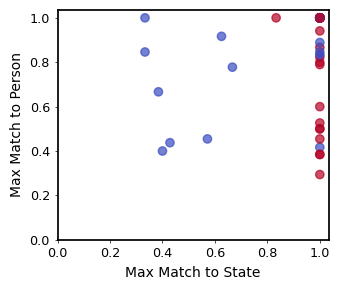

In [38]:
# Compute maximum edit distance proportion (1 - best similarity) for each row
person_edit_dist = df['person_best_sim']
state_edit_dist = df['state_best_sim']
# Ensure is_correct is binary (0/1) for coloring
is_correct_bin = pd.to_numeric(df['is_correct'], errors='coerce').fillna(0).astype(int)
plt.figure(figsize=(3.5, 3))
scatter = plt.scatter(state_edit_dist, person_edit_dist, c=is_correct_bin, cmap='coolwarm', alpha=0.7)
plt.xlabel('Max Match to State')
plt.ylabel('Max Match to Person')
plt.xlim(0)
plt.ylim(0)
plt.tight_layout()
plt.savefig('figures/AppD_b.png', dpi=300, transparent=True)
plt.show()

In [35]:
# If 'is_correct' is not numeric, try to convert
is_correct = pd.to_numeric(df['is_correct'], errors='coerce')
mean_is_correct = np.nanmean(is_correct)
print(f'Average is_correct: {mean_is_correct:.3f}')

Average is_correct: 0.714
